# Análise Estrutural & Elementos Finitos

In [1]:
import math
import numpy as np
import matplotlib as mplt
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import matplotlib.tri as mtri
import meshio
from scipy.spatial import Delaunay
import scipy as sp
import pandas as pd
import os                # Library used for system interaction (such as listing files in a directory,...)
import itertools as it   #biblioteca com funções de permutação a serem usadas na interação da matriz de conectividade com a global

## Funções de forma (ou interpolação)

In [3]:
#1D----------------------------------------------
##1ª ordem:
#Nh1 = [Nh11, Nh12, Nh13, Nh14]

def Nh11(x,X1,X2):
    l = X2 - X1
    return ((X2 - x)**2/l**3)*(2*(x - X1) + (X2 - X1))

def Nh12(x,X1,X2):
    l = X2 - X1
    return ((x - X2)**2*(x - X1))/l**2

def Nh13(x,X1,X2):
    l = X2 - X1
    return ((x - X1)**2/l**3)*(2*(X2 - x) + (X2 - X1))

def Nh14(x,X1,X2):
    l = X2 - X1
    return ((x - X1)**2*(x - X2))/l**2

#Bh1 = [Bh11, Bh12, Bh13, Bh14]

def Bh11(x,X1,X2):
    l = X2 - X1
    return - 6*(x - X1)*(X2 - x)/l**3

def Bh12(x,X1,X2):
    l = X2 - X1
    return (x - X2)*(3*x - 2*X1 - X2)/l**2

def Bh13(x,X1,X2):
    l = X2 - X1
    return - 6*(x - X1)*(x - X2)/l**3 

def Bh14(x,X1,X2):
    l = X2 - X1
    return (x - X1)*(3*x - X1 - 2*X2)/l**2

#dBh1 = [dBh11, dBh12, dBh13, dBh14]

def dBh11(x,X1,X2):
    l = X2 - X1
    return (12*x - 6*(X1 + X2))/l**3

def dBh12(x,X1,X2):
    l = X2 - X1
    return (6*x - 2*X1 - 4*X2)/l**2

def dBh13(x,X1,X2):
    l = X2 - X1
    return ((-12)*x + 6*(X1 + X2))/l**3

def dBh14(x,X1,X2):
    l = X2 - X1
    return (6*x - 4*X1 - 2*X2)/l**2


##  Viga sujeita a momento e carga distribuida

\begin{equation}
 \left\{ \begin{aligned}
         EI\frac{\partial^4 y}{\partial x^4} - p(x) = 0 \\
         y(L/2) = 0 \, , \;\; y(L) = 0 \\
         \theta(L/2) = 0 \, , \;\; \theta(L) = 0
        \end{aligned} 
 \right.
\end{equation}

$$ EI\frac{\partial^4 y}{\partial x^4} - p(x) = 0 $$


$$ \int_\Omega \left [ EI\frac{\partial^4 y}{\partial x^4} - p(x) \right ] \cdot \omega(x) \; d\Omega = 0 $$

Aplicando Toerema de Green para enfraquecer a equação:

$$ \int_{\Omega} EI\frac{\partial^3 y}{\partial x^3} \frac{\partial \omega(x)}{\partial x} \; d\Omega - \int_{\Gamma} EI\frac{\partial^3 y}{\partial x^3} \omega(x) \; d\Gamma - \int_{\Omega} p(x) \omega(x) \; d\Omega = 0 $$

Assumindo C.C.'s de Dirichlet:

$$ \int_{\Omega} EI\frac{\partial^3 y}{\partial x^3} \frac{\partial \omega(x)}{\partial x} \; d\Omega - \int_{\Omega} p(x) \omega(x) \; d\Omega = 0 $$

Repetindo o procedimento:

$$ \int_{\Omega} EI\frac{\partial^2 y}{\partial x^2} \frac{\partial^2 \omega(x)}{\partial x^2} \; d\Omega - \int_{\Gamma} EI\frac{\partial^2 y}{\partial x^2} \frac{\partial \omega(x)}{\partial x} \; d\Gamma - \int_{\Omega} p(x) \omega(x) \; d\Omega = 0 $$

$$ \int_{\Omega} EI\frac{\partial^2 y}{\partial x^2} \frac{\partial^2 \omega(x)}{\partial x^2} \; d\Omega - \int_{\Omega} p(x) \omega(x) \; d\Omega = 0 $$

Discretizando a formulação fraca:

$$ \sum_{i}^{\infty} \sum_{j}^{\infty} \int_{\Omega} EI\frac{\partial^2 (N_i y_i)}{\partial x^2} \frac{\partial^2 (N_j \omega_j)}{\partial x^2} \; d\Omega - \sum_{i}^{\infty} \sum_{j}^{\infty} \int_{\Omega} N_k p_k \cdot N_j \omega_j \; d\Omega = 0 $$

$$ \sum_{i}^{\infty} \sum_{j}^{\infty} EI \int_{\Omega} B'_i B'_j \; d\Omega \cdot y_i \omega_j - \sum_{i}^{\infty} \sum_{j}^{\infty} \int_{\Omega} N_k N_j \; d\Omega \cdot p_k \omega_j = 0 $$

Dividindo a equação por $\omega_j$ e substituindo os somatórios duplos por somatórios de elemento, a equação assume a seguinte forma: 

$$ \sum_{e}^{\infty} EI \int_{\Omega} B'_i B'_j \; d\Omega \cdot y_i - \sum_{e}^{\infty} \int_{\Omega} N_k N_j \; d\Omega \cdot p_k = 0 $$

As integrais das funções de interpolação correspondem a matrizes elementares de rigidez e carga:

$$ K^e = EI \int_{\Omega} B'_i B'_j \; d\Omega \;\;,\;\;\;\; Q^e = \int_{\Omega} N_i N_j \; d\Omega $$

Fazendo a montagem das matrizes globais $K$ e $Q$:

$$ K \cdot y_i - Q \cdot p_k = 0 $$

---

Outra forma de se abordar o problema é não utilizando função de interpolação para $p(x)$, uma vez que já se conhece a própria função de $p(x)$. Dessa forma chegamos a um vetor de carga em vez de uma matriz $Q$:

$$ \sum_{i}^{\infty} \sum_{j}^{\infty} EI \int_{\Omega} B'_i B'_j \; d\Omega \cdot y_i \omega_j - \sum_{i}^{\infty} \sum_{j}^{\infty} \int_{\Omega} N_j \; d\Omega \cdot p(x)_j \omega_j = 0 $$

Dividindo a equação por $\omega_j$ e substituindo os somatórios duplos por somatórios de elemento, a equação assume a seguinte forma:

$$ \sum_{e}^{\infty} EI \int_{\Omega} B'_i B'_j \; d\Omega \cdot y_i - \sum_{e}^{\infty} \int_{\Omega} N_j p_j \; d\Omega = 0 $$

As integrais das funções de interpolação correspondem à matriz elementar de rigidez $K$ e ao vetor de carga $Q$:

$$ K^e = EI \int_{\Omega} B'_i B'_j \; d\Omega \;\;,\;\;\;\; Q^e = \int_{\Omega} N_j p_j \; d\Omega $$

Fazendo a montagem das matrizes globais $K$ e $Q$:

$$ K \cdot y_i - Q = 0 $$

---

Solução analítica de viga biengastada sujeita a carga distribuida (Elementos de Máquina de Shigley - ):

$$ M = \frac{w}{12} (6Lx - 6x^2 - L^2) $$
$$ V = \frac{w}{2} (L - 2x) $$
$$ y = - \frac{w x^2}{24 E I} (L - x)^2 $$



c:\Users\João Pedro\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\linalg\linalg.py:2139: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


inf


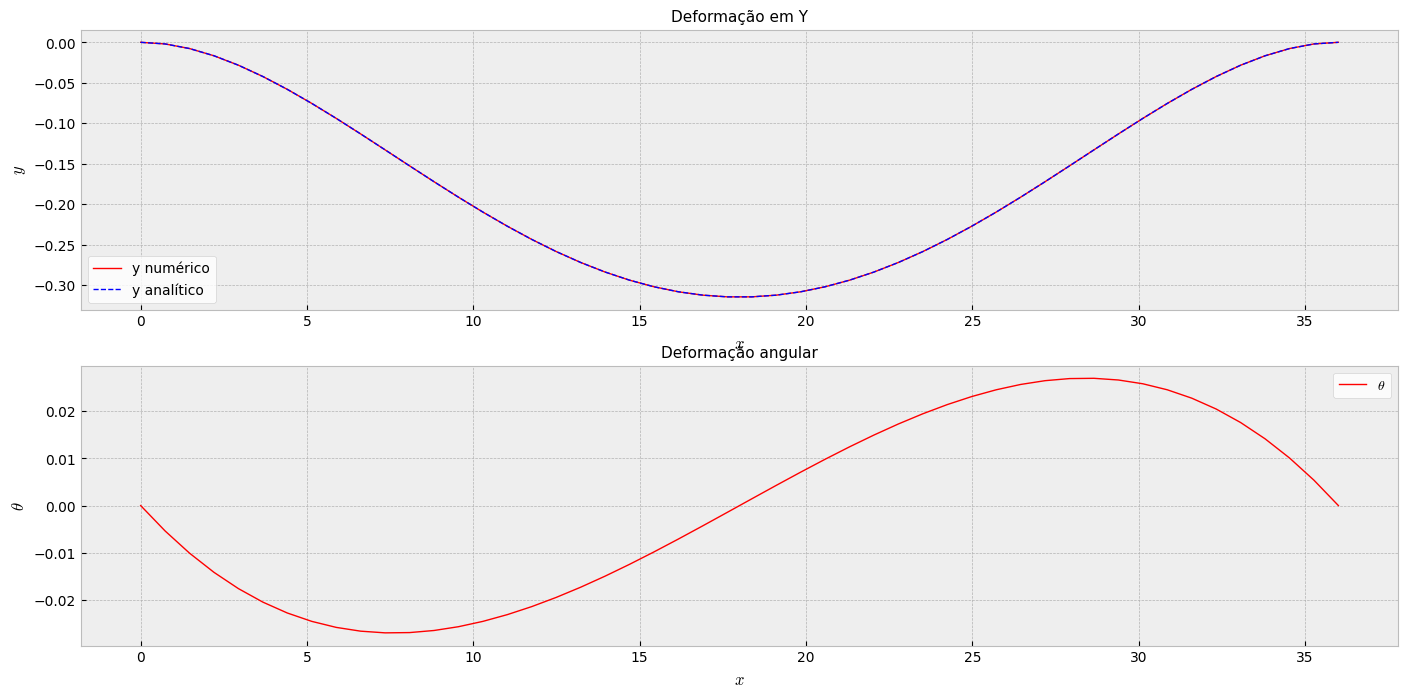

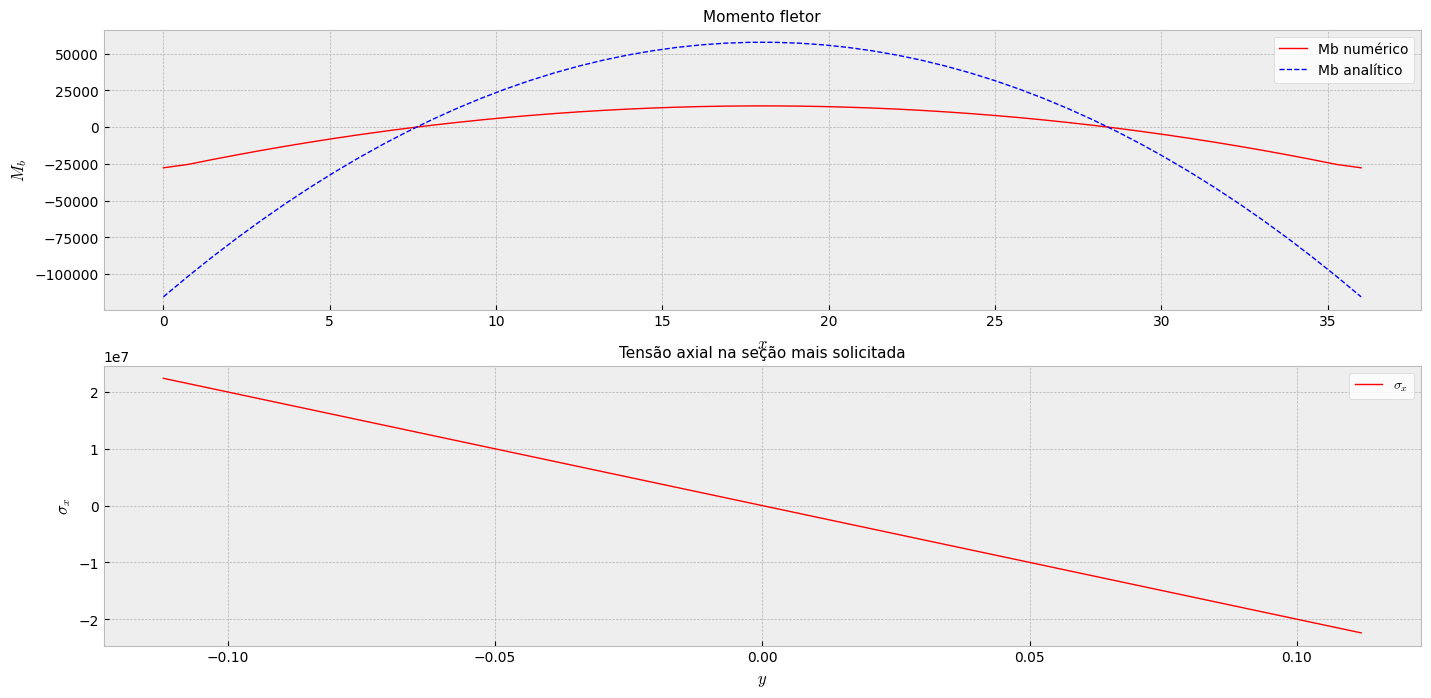

In [13]:
# parametros da simulacao

## malha
L = 36.0   # m
nx = 50
ne = nx-1
nGL = 2*nx

## CCs
Yo = 0.0
Yf = 0.0
Thetao = 0.0 #np.pi/12.0
Thetaf = 0.0 #np.pi/12.0

# propriedades da linha
d = 0.180  # m
t = 0.022   # m
D = d + 2.0*t   # m
A = np.pi*(D**2.0 - d**2.0)/4.0   # m^2
I = np.pi*(D**4.0 - d**4.0)/64.0   # m^4
E = 206.0*10.0**9.0   # GPa
rho = 7800.0   # kg/m^3
rho_l = rho*A   # kg/m

# carga
def q(x):
    return -9.81*rho_l

# geracao de malha 1D
X = np.linspace(0.0,L,nx)
dbX = np.stack((X,X))
dbX = dbX.transpose()
dbX = dbX.flatten()

IEN_GL = np.zeros( (ne,4),dtype='int' )
for e in range(0,ne):
  IEN_GL[e] = [2*e,2*e+1,2*e+2,2*e+3]

# lista de indices de condicao de contorno
##ccY = [999,nGL - 2]
##ccTheta = [1000,nGL - 1]
ccY = [0,nGL - 2]
ccTheta = [1,nGL - 1]

# vetor com valores das condicoes de contorno
Ycc = np.empty( (nGL),dtype='float' )

Ycc[ccY[0]] = Yo
Ycc[ccY[1]] = Yf

Thetacc = np.empty( (nGL),dtype='float' )

Thetacc[ccTheta[0]] = Thetao
Thetacc[ccTheta[1]] = Thetaf

# inicializacao das matrizes globais
K = np.zeros( (nGL,nGL),dtype='float' )
#Q = np.zeros( (nGL,nGL),dtype='float' )
Q = np.zeros( (nGL),dtype='float' )

# obtendo matrizes elementares
## funcoes de interpolacao
'''
K11 = lambda x,l : E*I*Bh11(x,l)*Bh11(x,l)
K12 = lambda x,l : E*I*Bh11(x,l)*Bh12(x,l)
K13 = lambda x,l:  E*I*Bh11(x,l)*Bh13(x,l)
K14 = lambda x,l : E*I*Bh11(x,l)*Bh14(x,l)
K21 = lambda x,l : E*I*Bh12(x,l)*Bh11(x,l)
K22 = lambda x,l : E*I*Bh12(x,l)*Bh12(x,l)
K23 = lambda x,l : E*I*Bh12(x,l)*Bh13(x,l)
K24 = lambda x,l : E*I*Bh12(x,l)*Bh14(x,l)
K31 = lambda x,l : E*I*Bh13(x,l)*Bh11(x,l)
K32 = lambda x,l : E*I*Bh13(x,l)*Bh12(x,l)
K33 = lambda x,l : E*I*Bh13(x,l)*Bh13(x,l)
K34 = lambda x,l : E*I*Bh13(x,l)*Bh14(x,l)
K41 = lambda x,l : E*I*Bh14(x,l)*Bh11(x,l)
K42 = lambda x,l : E*I*Bh14(x,l)*Bh12(x,l)
K43 = lambda x,l : E*I*Bh14(x,l)*Bh13(x,l)
K44 = lambda x,l : E*I*Bh14(x,l)*Bh14(x,l)
'''
K11 = lambda x,X1,X2 : dBh11(x,X1,X2)*dBh11(x,X1,X2)
K12 = lambda x,X1,X2 : dBh11(x,X1,X2)*dBh12(x,X1,X2)
K13 = lambda x,X1,X2:  dBh11(x,X1,X2)*dBh13(x,X1,X2)
K14 = lambda x,X1,X2 : dBh11(x,X1,X2)*dBh14(x,X1,X2)
K21 = lambda x,X1,X2 : dBh12(x,X1,X2)*dBh11(x,X1,X2)
K22 = lambda x,X1,X2 : dBh12(x,X1,X2)*dBh12(x,X1,X2)
K23 = lambda x,X1,X2 : dBh12(x,X1,X2)*dBh13(x,X1,X2)
K24 = lambda x,X1,X2 : dBh12(x,X1,X2)*dBh14(x,X1,X2)
K31 = lambda x,X1,X2 : dBh13(x,X1,X2)*dBh11(x,X1,X2)
K32 = lambda x,X1,X2 : dBh13(x,X1,X2)*dBh12(x,X1,X2)
K33 = lambda x,X1,X2 : dBh13(x,X1,X2)*dBh13(x,X1,X2)
K34 = lambda x,X1,X2 : dBh13(x,X1,X2)*dBh14(x,X1,X2)
K41 = lambda x,X1,X2 : dBh14(x,X1,X2)*dBh11(x,X1,X2)
K42 = lambda x,X1,X2 : dBh14(x,X1,X2)*dBh12(x,X1,X2)
K43 = lambda x,X1,X2 : dBh14(x,X1,X2)*dBh13(x,X1,X2)
K44 = lambda x,X1,X2 : dBh14(x,X1,X2)*dBh14(x,X1,X2)
'''
Q11 = lambda x,X1,X2 : Nh11(x,X1,X2)*Nh11(x,X1,X2)
Q12 = lambda x,X1,X2 : Nh11(x,X1,X2)*Nh12(x,X1,X2)
Q13 = lambda x,X1,X2 : Nh11(x,X1,X2)*Nh13(x,X1,X2)
Q14 = lambda x,X1,X2 : Nh11(x,X1,X2)*Nh14(x,X1,X2)
Q21 = lambda x,X1,X2 : Nh12(x,X1,X2)*Nh11(x,X1,X2)
Q22 = lambda x,X1,X2 : Nh12(x,X1,X2)*Nh12(x,X1,X2)
Q23 = lambda x,X1,X2 : Nh12(x,X1,X2)*Nh13(x,X1,X2)
Q24 = lambda x,X1,X2 : Nh12(x,X1,X2)*Nh14(x,X1,X2)
Q31 = lambda x,X1,X2 : Nh13(x,X1,X2)*Nh11(x,X1,X2)
Q32 = lambda x,X1,X2 : Nh13(x,X1,X2)*Nh12(x,X1,X2)
Q33 = lambda x,X1,X2 : Nh13(x,X1,X2)*Nh13(x,X1,X2)
Q34 = lambda x,X1,X2 : Nh13(x,X1,X2)*Nh14(x,X1,X2)
Q41 = lambda x,X1,X2 : Nh14(x,X1,X2)*Nh11(x,X1,X2)
Q42 = lambda x,X1,X2 : Nh14(x,X1,X2)*Nh12(x,X1,X2)
Q43 = lambda x,X1,X2 : Nh14(x,X1,X2)*Nh13(x,X1,X2)
Q44 = lambda x,X1,X2 : Nh14(x,X1,X2)*Nh14(x,X1,X2)
'''
Q11 = lambda x,X1,X2 : q(x)*Nh11(x,X1,X2)
Q12 = lambda x,X1,X2 : q(x)*Nh12(x,X1,X2)
Q13 = lambda x,X1,X2 : q(x)*Nh13(x,X1,X2)
Q14 = lambda x,X1,X2 : q(x)*Nh14(x,X1,X2)

## Funcao de integracao a ser usada
def INTEGRACAO_1(f,e):
     v1,v2,v3,v4 = IEN_GL[e]
     return sp.integrate.quad(f,dbX[v1],dbX[v3],(dbX[v1],dbX[v3]))[0]

## Integrando
kelem = np.empty((4,4,ne))
#qelem = np.empty((4,4,ne))
qelem = np.empty((4,ne))

for e in range(0,ne):
    Ke = E*I*np.array([[INTEGRACAO_1(K11,e),INTEGRACAO_1(K12,e),INTEGRACAO_1(K13,e),INTEGRACAO_1(K14,e)],
                       [INTEGRACAO_1(K21,e),INTEGRACAO_1(K22,e),INTEGRACAO_1(K23,e),INTEGRACAO_1(K24,e)],
                       [INTEGRACAO_1(K31,e),INTEGRACAO_1(K32,e),INTEGRACAO_1(K33,e),INTEGRACAO_1(K34,e)],
                       [INTEGRACAO_1(K41,e),INTEGRACAO_1(K42,e),INTEGRACAO_1(K43,e),INTEGRACAO_1(K44,e)]])     

    #Qe = np.array([[INTEGRACAO_1(Q11,e),INTEGRACAO_1(Q12,e),INTEGRACAO_1(Q13,e),INTEGRACAO_1(Q14,e)],
                   #[INTEGRACAO_1(Q21,e),INTEGRACAO_1(Q22,e),INTEGRACAO_1(Q23,e),INTEGRACAO_1(Q24,e)],
                   #[INTEGRACAO_1(Q31,e),INTEGRACAO_1(Q32,e),INTEGRACAO_1(Q33,e),INTEGRACAO_1(Q34,e)],
                   #[INTEGRACAO_1(Q41,e),INTEGRACAO_1(Q42,e),INTEGRACAO_1(Q43,e),INTEGRACAO_1(Q44,e)]]) 

    Qe = np.array([INTEGRACAO_1(Q11,e),INTEGRACAO_1(Q12,e),INTEGRACAO_1(Q13,e),INTEGRACAO_1(Q14,e)])

    kelem[:,:,e] = Ke
    #qelem[:,:,e] = Qe
    qelem[:,e] = Qe

for e in range(0,ne):

 for ilocal in range(0,4):
  iglobal = IEN_GL[e,ilocal]
  for jlocal in range(0,4):
   jglobal = IEN_GL[e,jlocal]

   K[iglobal,jglobal] += kelem[ilocal,jlocal,e]
   #Q[iglobal,jglobal] += qelem[ilocal,jlocal,e]

for e in range(0,ne):
 for ilocal in range(0,4):
  Q[2*e + ilocal] += qelem[ilocal,e]

#print(np.array_str(K, precision=2, suppress_small=True))
#print(np.array_str(Q, precision=2, suppress_small=True))

# definicao do sistema linear
A = K
#b = Q@q(dbX)
b = Q

# imposicao das c.c.s de Dirichlet em A e b
for i in ccY:
  A[i,:] = 0.0   # zerar linha
  A[i,i] = 1.0   # incluir 1 na diagonal

  b[i] = Ycc[i]

for i in ccTheta:
  A[i,:] = 0.0   # zerar linha
  A[i,i] = 1.0   # incluir 1 na diagonal

  b[i] = Thetacc[i]

print(np.linalg.det(A))


# solucao
cscA = sp.sparse.csc_matrix(A)   # Matrix form that improves sparse.linalg.solve
SOL = sp.sparse.linalg.spsolve(cscA,b)
#SOL = np.linalg.solve(A,b)
SOL = SOL.reshape((int(nGL/2),2))

Y = SOL[:,0]
Theta = SOL[:,1]

# curvatura
d2Y = np.empty(len(Y))

ho = 2*(X[1] - X[0])
d2Y[0] = (2*Y[1] - 2*Y[0])/ho**2

hf = 2*(X[-1] - X[-2])
d2Y[-1] = (- 2*Y[-1] + 2*Y[-2])/hf**2

for i in range(1,len(Y)-1):
    h = (X[i+1] - X[i-1])
    d2Y[i] = (Y[i+1] - 2*Y[i] + Y[i-1])/h**2

# momento fletor e momento fletor maximo
MbY = E*I*d2Y
MbYmax = E*I*np.max(d2Y)

# tensão axial na secao mais solicitada
Y_CrossSection = np.linspace(-D/2.0, D/2.0, nx)

sigmab = - MbYmax*Y_CrossSection/I

# solucao analitica #######################

def Mb_a(x,w,L):

  return -(w/12)*(6*L*x - 6*x**2 - L**2)  

def Y_a(x,w,L,E,I):

  return ((w*x**2)/(24*E*I))*(L - x)**2

# plotando ################################
plt.style.use('bmh')

fig1, ((ax1), (ax2)) = plt.subplots(2, sharey=False, sharex=False, figsize = (17,8))

ax1.plot(X,Y, color='red', linewidth=1.0, label=r'y numérico')
ax1.plot(X,Y_a(X,q(X),L,E,I), 'b--', linewidth=1.0, label=r'y analítico')
ax1.set_title('Deformação em Y',fontdict={'fontsize':11})
ax1.set_xlabel('$x$',fontdict={'fontsize':12})
ax1.set_ylabel('$y$',fontdict={'fontsize':12})
ax1.legend(loc='best',facecolor ='w')

ax2.plot(X,Theta, color='red', linewidth=1.0, label=r'$\theta$')
ax2.set_title('Deformação angular',fontdict={'fontsize':11})
ax2.set_xlabel('$x$',fontdict={'fontsize':12})
ax2.set_ylabel('$\\theta$',fontdict={'fontsize':12})
ax2.legend(loc='best',facecolor ='w')


fig1, ((ax3), (ax4)) = plt.subplots(2, sharey=False, sharex=False, figsize = (17,8))

ax3.plot(X,MbY, color='red', linewidth=1.0, label=r'Mb numérico')
ax3.plot(X,Mb_a(X,q(X),L), 'b--', linewidth=1.0, label=r'Mb analítico')
ax3.set_title('Momento fletor',fontdict={'fontsize':11})
ax3.set_xlabel('$x$',fontdict={'fontsize':12})
ax3.set_ylabel('$M_b$',fontdict={'fontsize':12})
ax3.legend(loc='best',facecolor ='w')

ax4.plot(Y_CrossSection,sigmab, color='red', linewidth=1.0, label=r'$\sigma_x$')
ax4.set_title('Tensão axial na seção mais solicitada',fontdict={'fontsize':11})
ax4.set_xlabel('$y$',fontdict={'fontsize':12})
ax4.set_ylabel('$\\sigma_x$',fontdict={'fontsize':12})
ax4.legend(loc='best',facecolor ='w')

plt.show()